In [1]:
# Imports
import sys
import numpy as np
import os
import scipy
#import tensorflow.keras.backend as K
import tensorflow.keras as kr

sys.path.insert(1, 'C:/Users/RIPPLE/source/repos/spwr-project/cnn-ripple/src/cnn');
print("Loading CNN model...", end=" ")
optimizer = kr.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)
model = kr.models.load_model("./model", compile=False)
model.compile(loss="binary_crossentropy", optimizer=optimizer)

print("Done!")
#model.summary()

def get_spwr_times(loaded_data, threshold, fs):
    '''''''''''''''''
    DOWNSAMPLE AND NORMALIZE AND GENERATE WINDOWS
    '''''''''''''''''
    from load_data import z_score_normalization, downsample_data
    # Downsample data
    downsampled_fs = 1250
    print("Downsampling data from %d Hz to %d Hz..."%(fs, downsampled_fs), end=" ")
    data = downsample_data(loaded_data, fs, downsampled_fs)
    print("Done!")

    # Normalize it with z-score
    print("Normalizing data...", end=" ")
    data = z_score_normalization(data)
    print("Done!")

    print("Shape of loaded data after downsampling and z-score: ", np.shape(data))

    overlapping = True
    window_size = 0.0128

    print("Generating windows...", end=" ")
    if overlapping:
        from load_data import generate_overlapping_windows
        
        stride = 0.0064

        # Separate the data into 12.8ms windows with 6.4ms overlapping
        X = generate_overlapping_windows(data, window_size, stride, downsampled_fs)
    else:
        stride = window_size
        X = np.expand_dims(data, 0)
    print("Done!")




    '''''''''''''''''
    DETECT RIPPLES
    '''''''''''''''''
    print("Detecting ripples...", end=" ")
    predictions = model.predict(X, verbose=True)
    print("Done!")




    '''''''''''''''''
    DETECT RIPPLES
    '''''''''''''''''
    from format_predictions import get_predictions_indexes

    # This threshold can be changed
    threshold = 0.97

    print("Getting detected ripples indexes and times...", end=" ")
    pred_indexes = get_predictions_indexes(data, predictions, window_size=window_size, stride=stride, fs=downsampled_fs, threshold=threshold)

    pred_times = pred_indexes / downsampled_fs
    print(pred_times.shape)
    print("Done!")


    '''''''''''''''''
    MERGE RIPPLES
    '''''''''''''''''
    #pred_indexes[:8, :]
    #pred_times

    ### Merge spwr ripples ###

    buffer=0.0128

    num_spwrs = 0
    spwr_start = pred_times[0, 0]
    spwr_end = pred_times[0, 1]

    curr_end = pred_times[0, 1]
    spwrs_times = []

    for i, (start_t, end_t) in enumerate(pred_times[1:, :]):
        if (start_t <= curr_end+buffer):
            curr_end = end_t
        else:
            spwr_end = curr_end
            spwrs_times.append((spwr_start, spwr_end))
            spwr_start = start_t
            curr_end = end_t

    spwrs_times_array = np.array(spwrs_times)
    spwrs_indexes_array = (spwrs_times_array * fs).astype(int)

    return spwrs_times_array, pred_times
    

Loading CNN model... WARNING:tensorflow:SavedModel saved prior to TF 2.5 detected when loading Keras model. Please ensure that you are saving the model with model.save() or tf.keras.models.save_model(), *NOT* tf.saved_model.save(). To confirm, there should be a file named "keras_metadata.pb" in the SavedModel directory.
Done!


## Load data

Loads data from the path specified in *datapath*. 

If you are using **your own data** please replace this code with your own methods to load it. By the end of this cell, loaded data must comply with the following conditions:
- It has to be a 2D numpy matrix (numpy.darray) with dimensions **(Number of samples x Number of channels)**.
- Number of channels has to be 8 (corresponding to a shank).
- The variable containing the loaded data must be named **loaded_data**.
- Data sampling rate must be saved in a variable named **fs** (in Hz).

In [2]:
'''''''''''''''''
LOAD DATA
'''''''''''''''''

import h5py
from scipy.io import savemat

work_dir = r"C:\Users\RIPPLE\source\repos\spwr-project\cnn-ripple\src\notebooks"

#Requires that the folder has manually curated labels
compare_labels=1


#data_dir = r"D:\Dropbox (Personal)\ETH_DATA\rTBY35\8_freely_behav_220517_120301"

### Rat 34 sessions ###
#data_dir = r"D:\Dropbox (Yanik Lab)\multiarea rat recordings\rTBY34\preprocessed_data\2_freely_behav_220304_132739"
#fileName = "2_freely_behav_220304_132739_LFP.mat"

#data_dir = r"D:\Dropbox (Yanik Lab)\multiarea rat recordings\rTBY34\preprocessed_data\5_freely_behav_220311_151222"
#fileName = "5_freely_behav_220311_151222_LFP.mat"

#data_dir = r"D:\Dropbox (Yanik Lab)\multiarea rat recordings\rTBY34\preprocessed_data\6_freely_behav_220315_133652"
#fileName = "6_freely_behav_220315_133652_LFP.mat"

#data_dir = r"D:\Dropbox (Yanik Lab)\multiarea rat recordings\rTBY34\preprocessed_data\9_freely_behav_220324_104927"
#fileName = "9_freely_behav_220324_104927_LFP.mat"

#data_dir = r"D:\Dropbox (Yanik Lab)\multiarea rat recordings\rTBY34\preprocessed_data\11_freely_behav_220331_141242"
#fileName = "11_freely_behav_220331_141242_LFP.mat"

#data_dir = r"D:\Dropbox (Yanik Lab)\multiarea rat recordings\rTBY34\preprocessed_data\13_freely_behav_220407_150008"
#fileName = "13_freely_behav_220407_150008_LFP.mat"


### Rat 35 ###
#data_dir = r"D:\Dropbox (Yanik Lab)\Multiarea rat recordings\rTBY35\preprocessed_data\13_freely_behav_220602_142621"
#fileName = "13_freely_behav_220602_142621_LFP.mat"

#data_dir = r"D:\Dropbox (Yanik Lab)\Multiarea rat recordings\rTBY35\preprocessed_data\15_freely_behav_220610_135314"
#fileName = "15_freely_behav_220610_135314_LFP.mat"

#data_dir = r"D:\Dropbox (Yanik Lab)\Multiarea rat recordings\rTBY35\preprocessed_data\25_freely_behav_220519_145946"
#fileName = "25_freely_behav_220519_145946_LFP.mat"


### Rat 37 ###
#data_dir = r"D:\Dropbox (Yanik Lab)\Multiarea rat recordings\rTBY37\preprocessed_data\13_freely_behav_220602_142621"
#fileName = "13_freely_behav_220602_142621_LFP.mat"


# For comparing manually labelled ripples with predicted ripples folder
data_dir = r"D:\Dropbox (Personal)\ETH_DATA\rTBY35\8_freely_behav_220517_120301"
filename='8_freely_behav_220517_120301_auto_features.mat'

# Load lfp and ripple data
os.chdir(data_dir)
f = h5py.File(filename,'r')

# Load lfp and ripple data
lfp_channels = np.array(f.get('lfp/data')) # (16, 7403751)
ripple_timestamps = np.array(f.get('ripples/timestamps')) #(2, 1467)

#If we want to compare manually curated labels
if(compare_labels):
    ripple_centralFrames = np.array(f.get('rippleEpisodes/centralFrames')).astype(int).transpose()
    g = scipy.io.loadmat('spwr_indicies.mat')
    high_dHP_bool = (g['bzHigh_dHP_ind'].flatten()).astype(bool)
    low_dHP_bool = (g['bzLow_dHP_ind'].flatten()).astype(bool)
    dHP_spwr_bool = np.logical_or(high_dHP_bool, low_dHP_bool)
    dHP_spwr_centralFrames = np.transpose(ripple_centralFrames[:, dHP_spwr_bool])

    high_iHP_bool = (g['bzHigh_iHP_ind'].flatten()).astype(bool)
    low_iHP_bool = (g['bzLow_iHP_ind'].flatten()).astype(bool)
    iHP_spwr_bool = np.logical_or(high_iHP_bool, low_iHP_bool)
    iHP_spwr_centralFrames = np.transpose(ripple_centralFrames[:, iHP_spwr_bool])

    print(np.shape(dHP_spwr_centralFrames))
    print(np.shape(iHP_spwr_centralFrames))
    
os.chdir(work_dir)

fs = 2000
loaded_data_dHP = np.transpose(lfp_channels[:8, :])
loaded_data_iHP = np.transpose(lfp_channels[8:, :])
print("Data shape: ", loaded_data_dHP.shape)
print("Data shape: ", loaded_data_iHP.shape)

### CAN CHANGE THIS ###
threshold=0.99

dHP_spwrs_times,pred_index_dHP = get_spwr_times(loaded_data_dHP,threshold=threshold,fs=2000)
iHP_spwrs_times,pred_index_iHP = get_spwr_times(loaded_data_iHP,threshold=threshold,fs=2000)

spwr_times = np.concatenate((dHP_spwrs_times, iHP_spwrs_times),axis=0)


n_spwr_dHP = dHP_spwrs_times.shape[0]
n_spwr_iHP = iHP_spwrs_times.shape[0]
print("Number of dHP spwrs: ", n_spwr_dHP)
print("Number of iHP spwrs: ", n_spwr_iHP)
print("Total number spwrs: ", n_spwr_dHP + n_spwr_iHP)

listdHP = ['dHP']*n_spwr_dHP
listiHP = ['iHP']*n_spwr_iHP

labels = listdHP + listiHP

spwr = {"spwr": spwr_times}
savemat(data_dir + "\spwr.mat", spwr)

label_struct = {"labels": np.transpose(np.asarray(labels,dtype='object'))}
savemat(data_dir + "\labels.mat", label_struct)


(878, 1)
(589, 1)
Data shape:  (7403751, 8)
Data shape:  (7403751, 8)
Downsampling data from 2000 Hz to 1250 Hz... Done!
Normalizing data... Done!
Shape of loaded data after downsampling and z-score:  (4627344, 8)
Generating windows... Done!
18076/18076 [==============================] - 273s 15ms/step
Done!
Getting detected ripples indexes and times... (4312, 2)
Done!
Downsampling data from 2000 Hz to 1250 Hz... Done!
Normalizing data... Done!
Shape of loaded data after downsampling and z-score:  (4627344, 8)
Generating windows... Done!
18076/18076 [==============================] - 266s 15ms/step
Done!
Getting detected ripples indexes and times... (3573, 2)
Done!
Number of dHP spwrs:  1481
Number of iHP spwrs:  1241
Total number spwrs:  2722


In [3]:
# Code for comparing manually labelled spwrs with predicted CNNRipple spwrs

#dHPs
print("#manually labelled ripples:",np.shape(dHP_spwr_centralFrames)[0])
print("#predicted ripples:",np.shape(dHP_spwrs_times)[0])

dHP_correct=0
for i in range(np.shape(dHP_spwr_centralFrames)[0]):
    centralTime = dHP_spwr_centralFrames[i,0]/fs  # Get the centralFrame timepoint
    for j in range(n_spwr_dHP):
        
        if(dHP_spwrs_times[j,0]< centralTime <dHP_spwrs_times[j,1]):
            dHP_correct += 1
print("#correct dHP ripples:",dHP_correct)

#iHPs
print("---------------------------")
print("#manually labelled ripples:",np.shape(iHP_spwr_centralFrames)[0])
print("#predicted ripples:",np.shape(iHP_spwrs_times)[0])

iHP_correct=0
for i in range(np.shape(iHP_spwr_centralFrames)[0]):
    centralTime = iHP_spwr_centralFrames[i,0]/fs  # Get the centralFrame timepoint
    for j in range(n_spwr_iHP):
        
        if(iHP_spwrs_times[j,0]< centralTime <iHP_spwrs_times[j,1]):
            iHP_correct += 1
print("#correct dHP ripples:",iHP_correct)


#manually labelled ripples: 878
#predicted ripples: 1481
#correct dHP ripples: 744
---------------------------
#manually labelled ripples: 589
#predicted ripples: 1241
#correct dHP ripples: 541


### Plot ripple detections

Does not currently work... Use MATLAB for visualisation of ripples instead

In [ ]:
#@markdown This is an interactive plot of the loaded data, where detected ripples are shown in blue. Data is displayed in chunks of 1 seconds and you can **move forward, backwards or jump to an specific second** using the control bar at the bottom.\
#@markdown \
#@markdown Run this cell to load the plotting method. Execute the **following** cell to use the method.

import matplotlib.pyplot as plt

def plot_all_ripples(k):
  data_size = data.shape[0]
  data_dur = data_size / downsampled_fs
  times = np.arange(data_size) / downsampled_fs

  if k >= times[-1]:
    printf("Data is only %ds long!"%(times[-1]))
    return
  elif k < 0:
    print("Please introduce a valid integer.")
    return

  #ini_idx = int(k * downsampled_fs)
  #end_idx = np.minimum(int((k+1) * downsampled_fs), data_size-1)
  ini_idx = 0
  end_idx = data_size-1

  pos_mat = list(range(data.shape[1]-1, -1, -1)) * np.ones((end_idx-ini_idx, data.shape[1]))

  fig = plt.figure(figsize=(30,20))
  ax = fig.add_subplot(1, 1, 1)
  ax.set_ylim(-3, 9)
  ax.margins(x=0)
  plt.tight_layout()
  plt.xlabel("Time (s)")


  lines = ax.plot(times[ini_idx:end_idx], data[ini_idx:end_idx, :]*1/np.max(data[ini_idx:end_idx, :], axis=0) + pos_mat, color='k', linewidth=1)

  fills = []
  for pred in pred_indexes:
      #if (pred[0] >= ini_idx and pred[0] <= end_idx) or (pred[1] >= ini_idx and pred[1] <= end_idx):
      rip_ini = (pred[0]) / downsampled_fs
      rip_end = (pred[1]) / downsampled_fs
      fill = ax.fill_between([rip_ini, rip_end], [-3, -3], [9, 9], color="tab:blue", alpha=0.3)
      fills.append(fill)

  plt.show()

print("Loaded!")

In [ ]:
plot_all_ripples(0)

In [ ]:
#@markdown This is an interactive plot of the loaded data, where detected ripples are shown in blue. Data is displayed in chunks of 1 seconds and you can **move forward, backwards or jump to an specific second** using the control bar at the bottom.\
#@markdown \
#@markdown Run this cell to load the plotting method. Execute the **following** cell to use the method.

import matplotlib.pyplot as plt

def plot_ripples(k, data,pred_indexes):

  downsampled_fs=1250

  data_size = data.shape[0]
  data_dur = data_size / downsampled_fs
  times = np.arange(data_size) / downsampled_fs

  if k >= times[-1]:
    printf("Data is only %ds long!"%(times[-1]))
    return
  elif k < 0:
    print("Please introduce a valid integer.")
    return

  ini_idx = int(k * downsampled_fs)
  end_idx = np.minimum(int((k+1) * downsampled_fs), data_size-1)
  #end_idx = np.minimum(int((k+0.2) * downsampled_fs), data_size-1)

  pos_mat = list(range(data.shape[1]-1, -1, -1)) * np.ones((end_idx-ini_idx, data.shape[1]))

  fig = plt.figure(figsize=(9.75,5))
  ax = fig.add_subplot(1, 1, 1)
  ax.set_ylim(-3, 9)
  ax.margins(x=0)
  plt.tight_layout()
  plt.xlabel("Time (s)")


  lines = ax.plot(times[ini_idx:end_idx], data[ini_idx:end_idx, :]*1/np.max(data[ini_idx:end_idx, :], axis=0) + pos_mat, color='k', linewidth=1)

  fills = []
  for pred in pred_indexes:
      if (pred[0] >= ini_idx and pred[0] <= end_idx) or (pred[1] >= ini_idx and pred[1] <= end_idx):
          rip_ini = (pred[0]) / downsampled_fs
          rip_end = (pred[1]) / downsampled_fs
          fill = ax.fill_between([rip_ini, rip_end], [-3, -3], [9, 9], color="tab:blue", alpha=0.3)
          fills.append(fill)

  plt.show()

print("Loaded!")

Loaded!


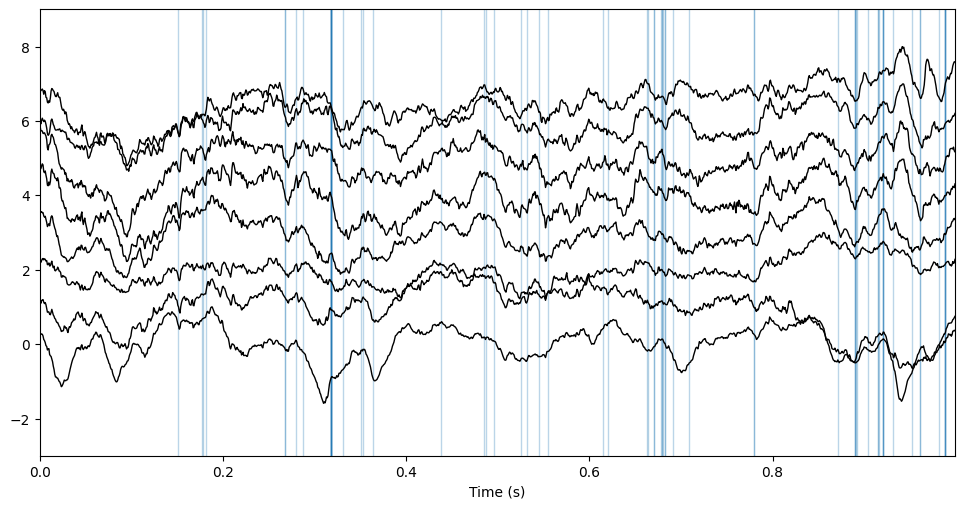

In [ ]:
plot_ripples(0,loaded_data_dHP,pred_index_dHP)

In [ ]:
#@title Time (in seconds) { run: "auto", vertical-output: true, display-mode: "form" }

#502 for beautiful ripples
#513.7 Good
#505 maybe fn?
#509.8 bad
#510 bad
#120.4-120.6
second =  530#@param {type:"integer"}

#plot_ripples(second)
%matplotlib notebook
from ipywidgets import *
import ipywidgets as widgets

interactive_plot = interact(plot_ripples, k = widgets.FloatText(value=1,min=0,max=np.max(np.arange(data.shape[0]) / downsampled_fs),step=0.5))
interactive_plot

In [ ]:
lfp_channels.shape
print(spwrs_indexes_array.shape)
spwrs_times_array.shape

In [ ]:
%matplotlib inline
for spwr_start, spwr_end in spwrs_indexes_array[100:500, :]:
    plt.figure()
    
    freq = 2000
    
    data_size = lfp_channels.shape[1]
    #data_dur = data_size / freq
    #times = np.arange(data_size) / freq
    
    #ini_idx = int(k * freq)
    #end_idx = np.minimum(int((k+0.1) * freq), data_size-1)
    
    #offset = 62
    ini_idx = np.maximum(spwr_start-50, 0)
    end_idx = np.minimum(spwr_end + 50, data_size-1)
    
    #pos_mat = list(range(data.shape[1]-1, -1, -1)) * np.ones((end_idx-ini_idx, data.shape[1]))
    
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(1, 1, 1)
    #ax.set_ylim(-3, 9)
    ax.margins(x=0)
    #plt.tight_layout()
    plt.xlabel("Time (ms)")
    
    #x_axis = range(ini_idx, end_idx)
    for j in range(8):
        plt.plot(lfp_channels[j, ini_idx:end_idx], linewidth=1)

    fills = []
    """
    for pred in spwrs_indexes_array:
        if (pred[0] >= ini_idx and pred[0] <= end_idx) or (pred[1] >= ini_idx and pred[1] <= end_idx):
            rip_ini = (pred[0]) / freq
            rip_end = (pred[1]) / freq
            fill = ax.fill_between([rip_ini, rip_end], [-3, -3], [9, 9], color="tab:blue", alpha=0.3)
            fills.append(fill)
    """
    plt.show()

    plt.close()

In [ ]:
np.max(lfp_channels)